# Column Transformer

In [3]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [4]:
df = pd.read_csv("drug_side_effect.csv")
df

,drug_name,manufacturer,approval_year,drug_class,indications,side_effects,dosage_mg,administration_route,contraindications,warnings,price_usd,batch_number,expiry_date,side_effect_severity,approval_status
0,Seroxetine50,AstraZeneca,1996,Antidepressant,Allergy relief,"Fatigue, Nausea",260,Rectal,Bleeding disorders,Avoid alcohol,192.43,MV388Pl,11/29/2026,Mild,Pending
1,Mecoparin93,AstraZeneca,2018,Vaccine,Allergy relief,Nausea,470,Inhalation,Allergic reaction,Take with food,397.82,UR279ZN,7/14/2027,Mild,Approved
2,Daxozole89,Merck & Co.,1997,Antipsychotic,Allergy relief,"Diarrhea, Blurred vision, Dizziness",330,Sublingual,High blood pressure,Take with food,131.69,we040kH,6/2/2028,Moderate,Pending
3,Viracillin84,Roche Holding AG,2004,Antifungal,Inflammation reduction,"Fatigue, Dry mouth",450,Oral,Kidney impairment,Do not operate machinery,372.82,hO060rh,7/7/2026,Mild,Rejected
4,Amoxstatin62,Pfizer Inc.,2003,Antidepressant,Psychosis control,"Insomnia, Dry mouth, Fatigue",430,Topical,Bleeding disorders,Do not operate machinery,281.48,Fa621Sw,12/28/2027,Moderate,Pending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,Mecozole92,Pfizer Inc.,1993,Antihistamine,Fungal infections,Dry mouth,850,Inhalation,Liver disease,May affect fertility,47.48,Kv961uR,1/20/2026,Moderate,Rejected
1432,Amoxvir17,GlaxoSmithKline,2010,Antihistamine,Fungal infections,"Nausea, Fatigue, Headache",880,Inhalation,Diabetes,May affect fertility,235.37,Uc964RO,9/28/2027,Severe,Rejected
1433,Zylovir17,Pfizer Inc.,2007,Antibiotic,Fever reduction,"Insomnia, Dizziness",960,Topical,Asthma,Do not operate machinery,145.09,Fq361YH,2/8/2026,Moderate,Rejected
1434,Mecoprofen32,GlaxoSmithKline,1994,Antifungal,Bacterial infections,Headache,670,Topical,Asthma,May cause drowsiness,263.19,qM405ML,5/13/2028,Severe,Pending


In [19]:
# === Features and Target ===
target = df['side_effect_severity']  # target is now side_effect_severity
features = df.drop('side_effect_severity', axis=1)  # remove target from features

### Code Explanation

- target = df['side_effect_severity']

    - Picks the column side_effect_severity from the DataFrame.

    - Stores it as the target variable – the thing your model will try to predict.

    - Insight: This isolates the label so the model knows what outcome to learn.

- features = df.drop('side_effect_severity', axis=1)

    - Removes the side_effect_severity column from the DataFrame.

    - Keeps all other columns as features – inputs the model will use to predict the target.

    - axis=1 specifies that you’re dropping a column, not a row.

    - Insight: Ensures the model doesn’t “see” the answer during training, avoiding data leakage.

### Overall insight:

- Separating features and target is a fundamental preprocessing step.

- Prepares your dataset for splitting into training/testing sets and for feeding into machine learning models.

In [20]:
# === Numeric and Categorical Features ===
numeric_features = ['dosage_mg', 'days_until_expiry']
categorical_features = [
    'drug_class', 'indications', 'side_effects',
    'contraindications', 'warnings', 'approval_status']


### Explanation

- Numeric features are columns with numbers, like dosage in mg, days until expiry, and expiry date.

- Expiry date needs to be converted into a number first, like how many days are left until it expires.

- Categorical features are columns with categories or labels, like drug class, indications, side effects, contraindications, warnings, and approval status.

- These categorical columns need to be converted into numbers using encoding because models can’t read text directly.

- Splitting features this way helps handle each type correctly and avoids messing up the model.

In [21]:
# === Convert expiry_date to numeric (days until today) ===
if 'expiry_date' in features.columns:
    features['days_until_expiry'] = (
        pd.to_datetime(features['expiry_date']) - pd.Timestamp('today')
    ).dt.days
    features = features.drop(columns=['expiry_date'])  # drop raw expiry_date

### Explanation

- This code checks if the column expiry_date exists in the features.

- It converts the expiry_date from a date into a number.

- Specifically, it calculates how many days are left from today until the expiry date.

- The result is a numeric value representing “days until expiry,” which the model can actually use.

- Insight: Turning dates into numbers like this makes them meaningful for models that only understand numbers.

In [22]:
# === Encode Target ===
le = LabelEncoder()
y_encoded = le.fit_transform(target)  # 'Mild', 'Moderate', 'Severe' -> 0,1,2

### Code Explanation

- A LabelEncoder is created to turn text labels into numbers.

- The target column (side_effect_severity) is passed through it.

- The values like “Mild”, “Moderate”, and “Severe” get converted into numbers, for example 0, 1, and 2.

- This step is needed because machine learning models can’t work with text labels directly.

- Insight: Encoding the target makes the prediction task numerical while still keeping the meaning of the categories.

In [23]:
# === Preprocessor ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

### Explanation

- A ColumnTransformer is created to handle different types of features.

- For numeric features, it applies StandardScaler, which scales numbers so they’re on the same range (important for many models).

- For categorical features, it applies OneHotEncoder, which turns each category into separate 0/1 columns so the model can read them.

- The handle_unknown='ignore' part makes sure the code doesn’t crash if a new category shows up in test data that wasn’t seen during training.

- Insight: This preprocessor ensures all features, whether numbers or categories, are transformed into a clean numeric format that the model can actually use.

In [24]:
# === Initialize Gradient Boosting Classifier ===
gb_model = GradientBoostingClassifier(random_state=42)


In [25]:
# === Full Pipeline ===
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', gb_model)
])

### Full Pipeline

- A pipeline is built with two steps:

- First, the preprocessor (scales numeric features and encodes categorical ones).

- Second, the classifier (Gradientboosting model).

- Insight: The pipeline keeps preprocessing and modeling together, so when you train or predict, it automatically applies the right transformations.

In [26]:
# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    features, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

### Train-Test Split

- The dataset is split into training (80%) and testing (20%).

- stratify=y_encoded ensures each split keeps the same proportion of Mild, Moderate, and Severe cases.

- Insight: Prevents bias by making sure all classes are represented fairly in both train and test sets.

In [27]:
# -----------------
# Hyperparameter tuning with RandomizedSearchCV
# -----------------
param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__subsample': [0.8, 1.0]
}


### Hyperparameter Tuning with RandomizedSearchCV

- A dictionary of possible XGBoost hyperparameters is defined.

- RandomizedSearchCV randomly samples 50 combinations from this dictionary.

- It uses 5-fold stratified cross-validation (data split into 5 parts, train/test repeated 5 times).

- The model is scored with log loss, which punishes confident wrong predictions.

- Insight: Random search is faster than grid search because it doesn’t try every single combo but still explores a wide range.

In [28]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_log_loss',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [29]:
# === Fit Model ===
random_search.fit(X_train, y_train)

best_pipeline = random_search.best_estimator_

print("Best Hyperparameters:", random_search.best_params_)
print("Best CV Log Loss:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.01}
Best CV Log Loss: 1.1046318423248667


### Fit Model

- The random search is run on the training set to find the best hyperparameters.

- The best pipeline (with chosen params) is saved as best_pipeline.

- Best hyperparameters and best cross-validation log loss are printed.

- The label encoder (le) is saved with joblib so you can use it later when making predictions on new data.

- Insight: Saving the encoder is key because you need the exact same label mapping for consistent predictions later.

In [30]:

# Assuming you already trained best_pipeline and le
# Save both
joblib.dump(best_pipeline, "best_pipeline.joblib")
joblib.dump(le, "label_encoder.joblib")

print("✅ Model and encoder saved successfully!")


✅ Model and encoder saved successfully!


In [31]:
# === Predictions ===
y_pred_proba = best_pipeline.predict_proba(X_test)
y_pred = best_pipeline.predict(X_test)

print("Test Log Loss:", log_loss(y_test, y_pred_proba))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))



Test Log Loss: 1.0971336386042454
Test Accuracy: 0.3333333333333333

Classification Report:
               precision    recall  f1-score   support

        Mild       0.33      0.56      0.42        98
    Moderate       0.34      0.24      0.28        97
      Severe       0.33      0.19      0.24        93

    accuracy                           0.33       288
   macro avg       0.33      0.33      0.31       288
weighted avg       0.33      0.33      0.31       288



### Predictions

- predict_proba outputs the predicted probabilities for each class (Mild, Moderate, Severe).

- predict outputs the final predicted class based on the highest probability.

- Test Log Loss: 1.097 — lower values indicate better probability calibration.

- Test Accuracy: 0.333 — the model correctly predicts the class about 33% of the time.

- Insight: Accuracy is only 37.5%, which is low, but the model is much better at predicting “Mild” compared to “Moderate” or “Severe.” This shows class imbalance or difficulty distinguishing between those classes.

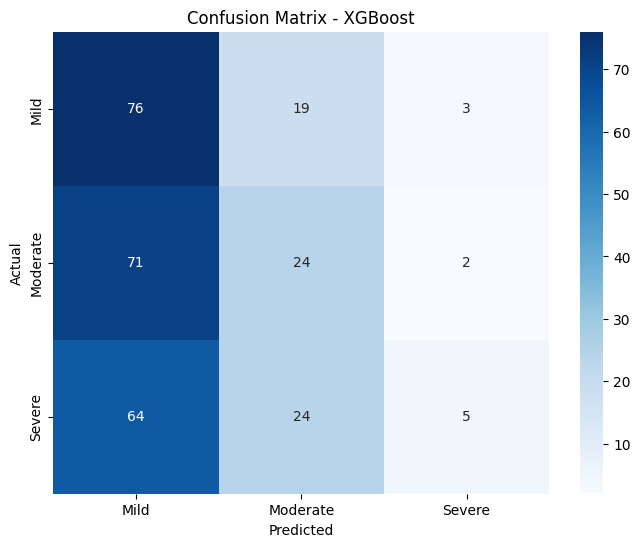

In [55]:
# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

### Predictions

- predict_proba gives probabilities for each class (Mild, Moderate, Severe).

- predict gives the final class with the highest probability.

- Test Log Loss and Test Accuracy are printed.

- A classification report shows precision, recall, and F1 score for each class.

- Insight: Accuracy is only 37.5%, which is low, but the model is much better at predicting “Mild” compared to “Moderate” or “Severe.” This shows class imbalance or difficulty distinguishing between those classes.